<a href="https://colab.research.google.com/github/Lee-Gunju/Lee-Gunju/blob/master/%5BBaseline%5D_CNN2RNN(ResNet50%2C_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

baseline.ipynb <br>
.. ├ models <br>
.. └ data <br>
.... ├ train_sdf <br>
.... ├ dev_sdf <br>
.... ├ test_sdf <br>
.... ├ train_imgs <br>
.... ├ test_imgs <br>
.... ├ sample_train.csv <br>
.... ├ sample_test.csv <br>
.... └ sample_submission.csv <br>

## 사용 패키지

In [1]:
pip install rdkit-pypi


     |████████████████████████████████| 18.6 MB 153 kB/s 


In [2]:
pip install rdkit

ERROR: Could not find a version that satisfies the requirement rdkit (from versions: none)
ERROR: No matching distribution found for rdkit


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import gdown
import re
import zipfile


In [4]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('rdkit version :', rdkit.__version__)
print('torch version :', torch.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.1.2
rdkit version : 2021.03.4
torch version : 1.9.0+cu102


## 데이터 로드

In [5]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z"

In [6]:
## data download 받고(gdown.download 사용) 압축 풀기
gdown.download(url, 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip', 'r') as z_fp:
  z_fp.extractall('./data')

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z
To: /content/data.zip
32.0MB [00:00, 44.5MB/s]


In [7]:
train = pd.read_csv('./data/train.csv')
dev = pd.read_csv('./data/dev.csv')

In [8]:
train.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [9]:
dev.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,dev_0,O=C1c2ccccc2C2(c3ccccc31)c1ccccc1N(c1ccc(-c3nc...,2.7609,2.7540
1,dev_1,Cc1cccc2c3ccccc3n(-c3ccc(-c4c(-c5ccccc5)c(C#N)...,3.0495,3.0163
2,dev_2,CC1(C)c2ccccc2-c2ccc(-c3c(F)c(F)c(-c4ccc5c(c4)...,2.8314,2.1412
3,dev_3,CC(C)(C)c1ccc2c(c1)B1c3cc(C(C)(C)C)ccc3Oc3cc(-...,3.1813,2.9424
4,dev_4,O=C1c2cc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)ccc2S...,2.9559,2.7362


In [10]:
train = pd.concat([train, dev])

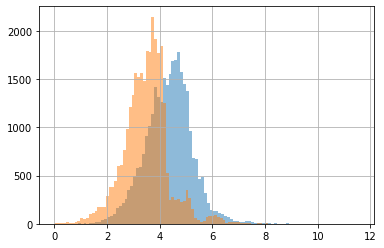

In [11]:
train['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train['T1_energy(eV)'].hist(bins=100, alpha=0.5)
plt.show()

## 데이터 전처리

분자의 구조적 특성을 찾기 위해 SMILES와 분자구조 이미지를 사용하였습니다.

In [12]:
! dir
#path = "data/train_imgs"
!mkdir "data/train_imgs"


data  data.zip	sample_data


In [13]:
for idx, row in tqdm(train.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'data/train_imgs/{file}.png')

30345it [06:06, 82.87it/s]


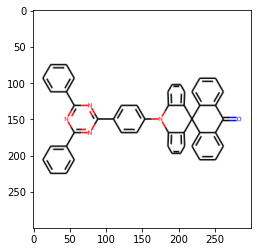

In [14]:
sample_img = cv2.imread('./data/train_imgs/dev_0.png')
plt.imshow(sample_img)
plt.show()

## 하이퍼파라미터

In [15]:
device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 25
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = f'./models/best_model.pt'

## SMILES Tokenizing

In [16]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [17]:
max_len = train.SMILES.str.len().max()
max_len

265

In [18]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [19]:
train.SMILES

0      CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N
1     COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...
2      CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1
3                             OC(CNC1CC1)CN1CCc2sccc2C1
4                        CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1
                            ...                        
66    N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...
67    CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...
68    Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...
69    Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...
70    CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2-c1c(Cl...
Name: SMILES, Length: 30345, dtype: object

In [20]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = ('./data/train_imgs/'+train.uid+'.png').to_numpy()

100%|██████████| 30345/30345 [00:00<00:00, 67171.64it/s]


## 학습 데이터셋

In [21]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

In [22]:
train_imgs = imgs[:27000]
train_seqs = seqs[:27000]
train_labels = labels[:27000]
val_imgs = imgs[27000:]
val_seqs = seqs[27000:]
val_labels = labels[27000:]

In [23]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((27000,), (27000, 265), (27000, 2), (3345,), (3345, 265), (3345, 2))

In [24]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [25]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
sample_batch = next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()

(torch.Size([64, 3, 300, 300]), torch.Size([64, 265]), torch.Size([64, 2]))

In [28]:
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

(torch.float32, torch.int64, torch.float32)

## 모델

ResNet50에 LSTM을 연결한 CNN2RNN 모델

In [29]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet50(pretrained=vision_pretrain)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [30]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)

    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        hidden, _ = self.lstm(embedded)
        hidden = hidden.view(hidden.size(0), -1)
        output = nn.ReLU()(self.final_layer(hidden))
        return output

In [31]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [32]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## 학습 정의

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [34]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss = criterion(output, label)
            
        return loss

## 학습

In [37]:
!mkdir "./models"

In [41]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
422it [04:08,  1.70it/s, Epoch=1, Loss=0.309832, Total Loss=0.335094]
53it [00:24,  2.19it/s, Epoch=1, Val Loss=0.478600, Total Val Loss=0.337450]
422it [04:13,  1.66it/s, Epoch=2, Loss=0.364187, Total Loss=0.288515]
53it [00:24,  2.15it/s, Epoch=2, Val Loss=0.377542, Total Val Loss=0.346139]
422it [04:13,  1.66it/s, Epoch=3, Loss=0.237637, Total Loss=0.263378]
53it [00:24,  2.17it/s, Epoch=3, Val Loss=0.279175, Total Val Loss=0.303065]
422it [04:13,  1.66it/s, Epoch=4, Loss=0.209797, Total Loss=0.241990]
53it [00:24,  2.15it/s, Epoch=4,

## 학습 결과

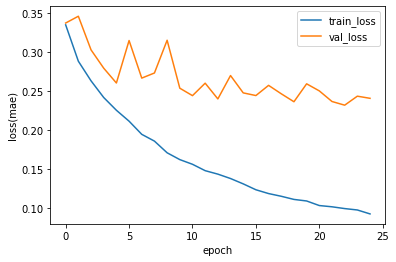

In [43]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

## 모델 복원

In [44]:
model = torch.load(save_path)

## 테스트 데이터 및 제출 양식 로드

In [45]:
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

## 테스트 데이터 전처리

In [42]:
!mkdir 'data/test_imgs'

In [46]:
for idx, row in tqdm(test.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'./data/test_imgs/{file}.png')

602it [00:07, 75.61it/s]


## 테스트 데이터셋

In [47]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('./data/test_imgs/'+test.uid+'.png').to_numpy()

100%|██████████| 602/602 [00:00<00:00, 56691.24it/s]


In [48]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 추론 및 제출

In [49]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        gap = output[:, 0] - output[:, 1]
        gap = np.where(gap<0, 0, gap)
        result.extend(list(gap))
        
    return result

In [50]:
pred = predict(test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [51]:
submission['ST1_GAP(eV)'] = pred

In [52]:
submission

,uid,ST1_GAP(eV)
0,test_0,0.987809
1,test_1,2.359563
2,test_2,0.851363
3,test_3,0.995866
4,test_4,1.330370
...,...,...
597,test_597,0.232878
598,test_598,0.085582
599,test_599,0.313631
600,test_600,0.686232


In [53]:
submission.to_csv('dacon_baseline.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [59]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl


Processing ./dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [63]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    '/content/dacon_baseline.csv', 
    'c4d90e2aea89b4c69abe2a9a4d55fedf79e7221f564e382f74ef1f94bbc165d7', 
    '235789', 
    'CAU_KElab', 
    'CAU_KElab_baseline'
)

exception occurs. 예외가 발생했습니다 unhashable type: 'dict'


# Public LB Score : 0.19445